## Creating The Ensemble
### (Mobilenet, Densenet and Effecientnet)

## 1. Mount Google Drive


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Imports

In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

## 3. Reproducibility

In [ ]:
SEED = 83
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

## 4. Paths & Parameters

In [32]:
data_dir = "/content/drive/My Drive/My_Plant_Proj/Dataset/Dataset"
valid_dir = f"{data_dir}/valid"
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
MAX_PER_CLASS = 180

## 5. Collect Limited Validation Images Per Class

In [33]:
def get_limited_image_paths(directory, max_per_class=180):
    image_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            all_images = os.listdir(class_path)
            selected_images = all_images[:max_per_class]
            for img in selected_images:
                image_paths.append(os.path.join(class_path, img))
                labels.append(class_name)
    return pd.DataFrame({"filename": image_paths, "class": labels})

valid_df = get_limited_image_paths(valid_dir, MAX_PER_CLASS)

## 6. Plot Class Distribution

<ipython-input-34-0e92d4280591>:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


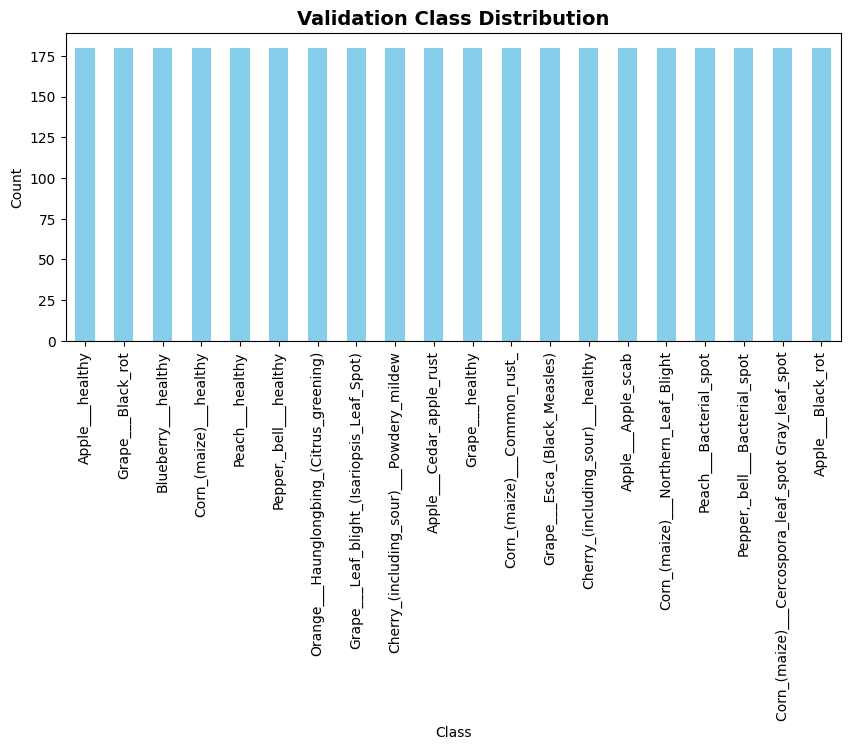

In [34]:
plt.figure(figsize=(10, 4))
valid_df['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Validation Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 7. Data Generator

In [35]:
valid_datagen = ImageDataGenerator(rescale=1./255)  # just for mapping
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df, directory=None, x_col="filename", y_col="class",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

label_map = valid_generator.class_indices  # Needed for y_true labels

Found 3600 validated image filenames belonging to 20 classes.


## 8. Load Models

In [36]:
model1 = tf.keras.models.load_model("/content/drive/My Drive/My_Plant_Proj/Dataset/densenet121_finetuned.h5")
model2 = tf.keras.models.load_model("/content/drive/My Drive/My_Plant_Proj/Dataset/mobilenetv2_finetuned.h5")
model3 = tf.keras.models.load_model("/content/drive/My Drive/My_Plant_Proj/Dataset/efficientnetb0_final.h5")

## 9. Preprocess Validation Images for Each Base Model

In [37]:
# --- Load and preprocess validation images manually ---
def load_images(df, target_size, preprocess_fn):
    images = []
    for path in df['filename']:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        img_array = preprocess_fn(img_array)
        images.append(img_array)
    return np.array(images)

# Load all images once (original)
valid_images_densenet = load_images(valid_df, IMG_SIZE, densenet_preprocess)
valid_images_mobilenet = load_images(valid_df, IMG_SIZE, mobilenet_preprocess)
valid_images_efficientnet = load_images(valid_df, IMG_SIZE, efficientnet_preprocess)

# Ground truth labels
label_map = valid_generator.class_indices
y_true = np.array([label_map[label] for label in valid_df["class"]])
y_true_cat = to_categorical(y_true, num_classes=len(label_map))  # if needed


## 10. Predict & Ensemble (Weighted)

In [39]:
print("🔍 Predicting with DenseNet121...")
preds1 = model1.predict(valid_images_densenet, batch_size=BATCH_SIZE, verbose=1)

print("🔍 Predicting with MobileNetV2...")
preds2 = model2.predict(valid_images_mobilenet, batch_size=BATCH_SIZE, verbose=1)

print("🔍 Predicting with EfficientNetB0...")
preds3 = model3.predict(valid_images_efficientnet, batch_size=BATCH_SIZE, verbose=1)

🔍 Predicting with DenseNet121...
57/57 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step
🔍 Predicting with MobileNetV2...
57/57 ━━━━━━━━━━━━━━━━━━━━ 55s 940ms/step
🔍 Predicting with EfficientNetB0...
57/57 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step


## 11. Finding Best Weights Combination

In [40]:
from itertools import product

# y_true = valid_generator.classes

def find_best_weights(preds_list, y_true, step=0.1):
    """
    Brute-force search over weight combinations that sum to 1.
    """
    best_acc = 0
    best_weights = None
    best_preds = None

    # Generate combinations of weights (w1, w2, w3) that sum to 1
    for w1, w2 in product(np.arange(0, 1+step, step), repeat=2):
        w3 = 1 - (w1 + w2)
        if w3 < 0 or w3 > 1:
            continue

        weights = [w1, w2, w3]
        ensemble = sum(w * p for w, p in zip(weights, preds_list))
        y_pred = np.argmax(ensemble, axis=1)
        acc = accuracy_score(y_true, y_pred)

        if acc > best_acc:
            best_acc = acc
            best_weights = weights
            best_preds = y_pred

    return best_weights, best_acc, best_preds


## 12. Making the weighted Ensemble

In [41]:
# Perform weighted ensemble search
preds_list = [preds1, preds2, preds3]
best_weights, best_acc, best_y_pred = find_best_weights(preds_list, y_true, step=0.01)

print(f"🔍 Best Weights Found: {best_weights:}")
print(f"✅ Best Ensemble Accuracy: {best_acc:.4f}")

# Using best predictions for evaluation
y_pred = best_y_pred


🔍 Best Weights Found: [np.float64(0.03), np.float64(0.53), np.float64(0.43999999999999995)]
✅ Best Ensemble Accuracy: 0.9828


# Visualisation and Results

## 1. Confusion Matrix

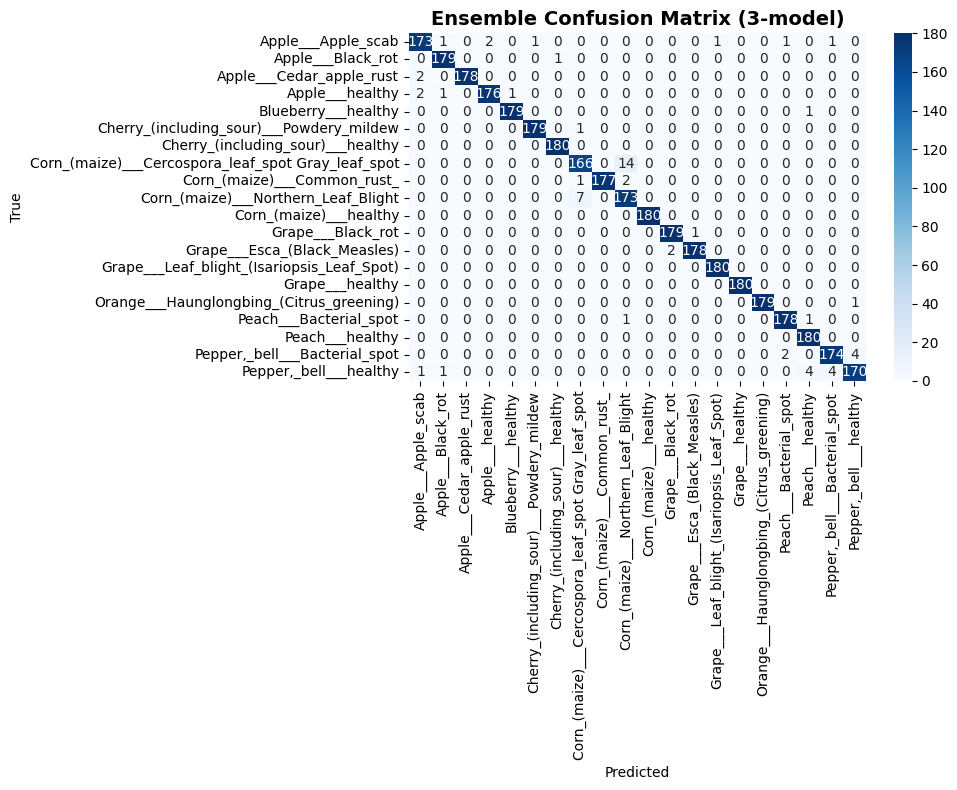

In [43]:
# ✅ Define class labels for heatmap
class_labels = list(label_map.keys())

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Ensemble Confusion Matrix (3-model)", fontsize=14, fontweight='bold')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## 2. Per Class Accuracy **Plot**

<ipython-input-44-4b28a6b6e524>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_accuracy, palette="viridis")


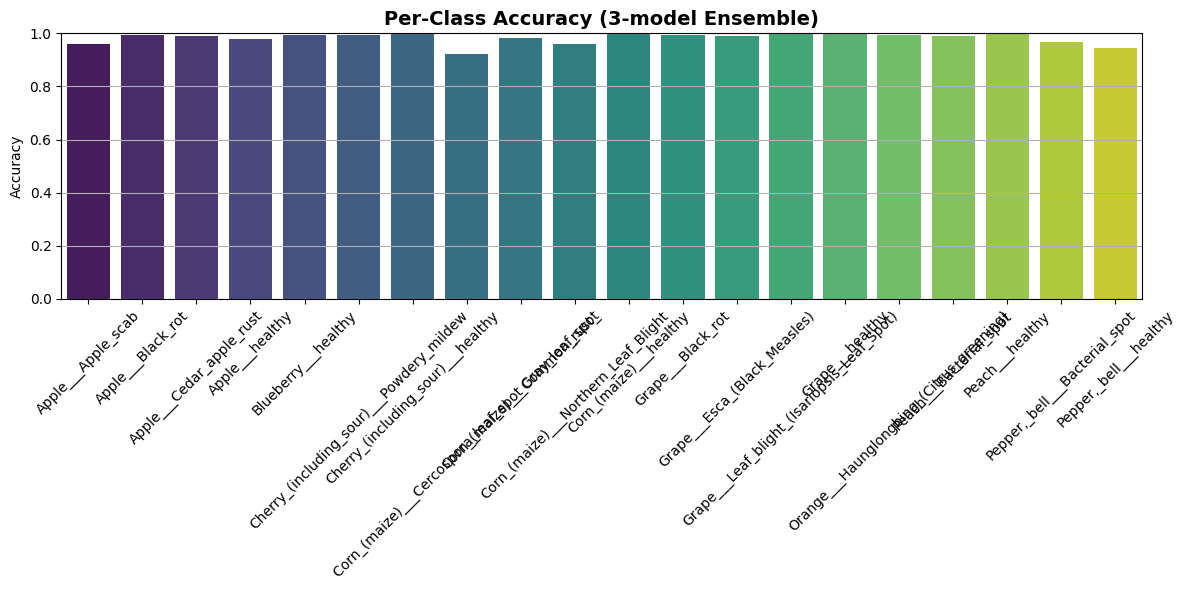

In [44]:
class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
class_accuracy = class_correct / class_total

plt.figure(figsize=(12, 6))
sns.barplot(x=class_labels, y=class_accuracy, palette="viridis")
plt.title("Per-Class Accuracy (3-model Ensemble)", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 3. Average Validation Metrics

In [47]:
avg_precision = precision_score(y_true, y_pred, average='macro')
avg_recall = recall_score(y_true, y_pred, average='macro')
avg_f1 = f1_score(y_true, y_pred, average='macro')
avg_accuracy = accuracy_score(y_true, y_pred)

print("\n🔍 Average Validation Metrics (Macro):")
print(f"🎯 Precision: {avg_precision:.4f}")
print(f"📥 Recall:    {avg_recall:.4f}")
print(f"💡 F1-Score:  {avg_f1:.4f}")
print(f"📊 Ensemble Accuracy:  {avg_accuracy:.4f}")


🔍 Average Validation Metrics (Macro):
🎯 Precision: 0.9830
📥 Recall:    0.9828
💡 F1-Score:  0.9828
📊 Ensemble Accuracy:  0.9828


## 4. Classification Report

In [48]:
print("Classification Report (3-model Ensemble):\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report (3-model Ensemble):

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.96      0.97       180
                                 Apple___Black_rot       0.98      0.99      0.99       180
                          Apple___Cedar_apple_rust       1.00      0.99      0.99       180
                                   Apple___healthy       0.99      0.98      0.98       180
                               Blueberry___healthy       0.99      0.99      0.99       180
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       180
                 Cherry_(including_sour)___healthy       0.99      1.00      1.00       180
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.92      0.94       180
                       Corn_(maize)___Common_rust_       1.00      0.98      0.99       180
               Corn_(maize)___Northe